# Notebook 1.4 - PyTorch - image recognition

The purpose of this notebook is to learn:
- how from strach build feed-forward NN
- how to load data using ```datasets``` and ```dataloader```

## Required packages


In [ ]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip instal matplotlib
! pip install numpy

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
torch.manual_seed(42)

## Load CIFAR10 dataset
A small dataset containing 32x32 images of 10 different clases (airplane, automoblie, bird ...). Total amount of images is 60k, 6k per class.


In [3]:
cifar10 = datasets.CIFAR10('./cifar10', train=True, download=True)
cifar10_val = datasets.CIFAR10('./cifar10', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


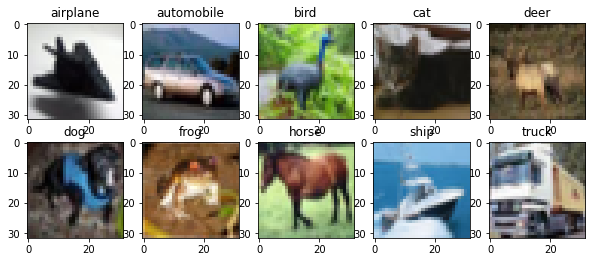

In [4]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
num_classes = len(class_names)
for i in range(num_classes):
    img = next(img for img, label in cifar10 if label == i)
    p1 = i // 5
    p2 = i % 5
    axes[p1,p2].imshow(img)
    axes[p1,p2].set_title(class_names[i])
plt.show()

## The Dataset class


In [5]:
type(cifar10)

torchvision.datasets.cifar.CIFAR10

In [6]:
isinstance(cifar10, torch.utils.data.Dataset)

True

It provides two methods: ```__len__``` and ```__getitem__```.

In [7]:
print(len(cifar10))
print(len(cifar10_val))

50000
10000


img = <PIL.Image.Image image mode=RGB size=32x32 at 0x21BE6007220>


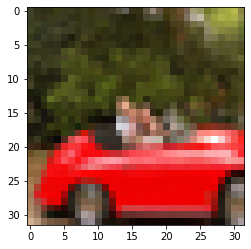

label = 1 -> automobile


In [8]:
img, label = cifar10[99]
print("img = {}".format(img))
plt.imshow(img)
plt.show()
print("label = {} -> {}".format(label,class_names[label]))

PIL = Python Imaging Library

## Transforms 
After data is loaded but before it is returned bz getitem

In [9]:
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [10]:
to_tensor = transforms.ToTensor()
img, label = cifar10[99]
print("img type = {}".format(type(img)))
img_t = to_tensor(img)
print("img_t type = {}".format(type(img_t)))
print(img_t.shape)

img type = <class 'PIL.Image.Image'>
img_t type = <class 'torch.Tensor'>
torch.Size([3, 32, 32])


In [11]:
cifar10 = datasets.CIFAR10('./cifar10', train=True, download=False,
                          transform=transforms.ToTensor())

type = <class 'torch.Tensor'>
shape = torch.Size([3, 32, 32])
dtype = torch.float32
range = 0.0-1.0


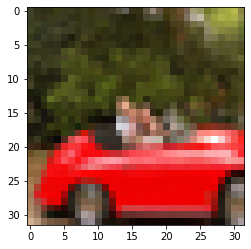

In [12]:
img, label = cifar10[99]
print("type = {}".format(type(img)))
print("shape = {}".format(img.shape))
print("dtype = {}".format(img.dtype))
print("range = {}-{}".format(img.min(),img.max()))
plt.imshow(img.permute(1,2,0))
plt.show()

### Normalize data

In [13]:
imgs = torch.stack([img for img, _ in cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [14]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [15]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [16]:
cifar10 = datasets.CIFAR10('./cifar10', train=True, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

In [17]:
cifar10_val = datasets.CIFAR10('./cifar10', train=False, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                          ]))

range = -1.9806982278823853-2.126077890396118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


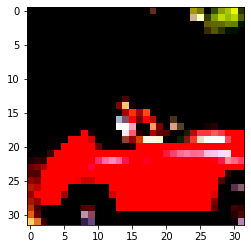

In [19]:
img, label = cifar10[99]
print("range = {}-{}".format(img.min(),img.max()))
plt.imshow(img.permute(1, 2, 0))
plt.show()

## Create binary classifier
Airplane vs Bird

In [65]:
label_map = {0: 0, 2: 1}
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [24]:
torch.manual_seed(42)
model1 = torch.nn.Sequential(
            torch.nn.Linear(3072, 512),
            torch.nn.Tanh(),
            torch.nn.Linear(512, 2))

### Compare softmax-s

In [28]:
x = torch.tensor([[1.0, 2.0, 3.0],
                  [10.0, 0.0, -3.0]])
softmax = torch.nn.Softmax(dim=1)
softmax(x)

tensor([[9.0031e-02, 2.4473e-01, 6.6524e-01],
        [9.9995e-01, 4.5398e-05, 2.2602e-06]])

In [33]:
def my_softmax(x, dim):
    y = torch.exp(x)
    return y/torch.sum(y, dim=dim).unsqueeze(dim)

In [34]:
my_softmax(x, 1)

tensor([[9.0031e-02, 2.4473e-01, 6.6524e-01],
        [9.9995e-01, 4.5398e-05, 2.2602e-06]])

In [38]:
torch.manual_seed(42)
model2 = torch.nn.Sequential(
            torch.nn.Linear(3072, 512),
            torch.nn.Tanh(),
            torch.nn.Linear(512, 2),
            torch.nn.Softmax(dim=1))

In [35]:
log_softmax = torch.nn.LogSoftmax(dim=1)
log_softmax(x)

tensor([[-2.4076e+00, -1.4076e+00, -4.0761e-01],
        [-4.7683e-05, -1.0000e+01, -1.3000e+01]])

In [36]:
torch.log(softmax(x))

tensor([[-2.4076e+00, -1.4076e+00, -4.0761e-01],
        [-4.7685e-05, -1.0000e+01, -1.3000e+01]])

In [37]:
torch.exp(log_softmax(x))

tensor([[9.0031e-02, 2.4473e-01, 6.6524e-01],
        [9.9995e-01, 4.5398e-05, 2.2602e-06]])

In [68]:
def training(n_epochs, model, loss_fnc, optimizer, data):
     

In [80]:
torch.manual_seed(42)
model3 = torch.nn.Sequential(
            torch.nn.Linear(3072, 512),
            torch.nn.Tanh(),
            torch.nn.Linear(512, 2),
            torch.nn.LogSoftmax(dim=1))
loss_fnc = torch.nn.NLLLoss() #Negative log likelihood loss
optimizer = torch.optim.SGD(model3.parameters(), lr=1e-2)
n_epochs = 100
for epoch in range(1,n_epochs+1):
    for img, label in cifar2:
        y_p = model3(img.view(-1).unsqueeze(0))
        loss = loss_fnc(y_p, torch.tensor([label]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))   

Epoch: 1, Loss: 2.927469
Epoch: 2, Loss: 3.565078
Epoch: 3, Loss: 8.009314


KeyboardInterrupt: 

In [74]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
torch.manual_seed(42)
model3 = torch.nn.Sequential(
            torch.nn.Linear(3072, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 2),
            torch.nn.LogSoftmax(dim=1))
optimizer = torch.optim.SGD(model3.parameters(), lr=1e-2)
loss_fn = torch.nn.NLLLoss()
n_epochs = 100
for epoch in range(1, n_epochs+1):
    for imgs, labels in train_loader:
        outputs = model3(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 1, Loss: 0.377674
Epoch: 2, Loss: 0.610707
Epoch: 3, Loss: 0.356401
Epoch: 4, Loss: 0.702709
Epoch: 5, Loss: 0.443264
Epoch: 6, Loss: 0.290993
Epoch: 7, Loss: 0.570458
Epoch: 8, Loss: 0.470892
Epoch: 9, Loss: 0.420264
Epoch: 10, Loss: 0.690238
Epoch: 11, Loss: 0.297737
Epoch: 12, Loss: 0.193162
Epoch: 13, Loss: 0.161635
Epoch: 14, Loss: 0.193924
Epoch: 15, Loss: 0.494018
Epoch: 16, Loss: 0.406848
Epoch: 17, Loss: 0.641391
Epoch: 18, Loss: 0.159939
Epoch: 19, Loss: 0.219787
Epoch: 20, Loss: 0.358275
Epoch: 21, Loss: 0.201897
Epoch: 22, Loss: 0.193696
Epoch: 23, Loss: 0.185463
Epoch: 24, Loss: 0.158973
Epoch: 25, Loss: 0.186689
Epoch: 26, Loss: 0.234984
Epoch: 27, Loss: 0.231136
Epoch: 28, Loss: 0.185850
Epoch: 29, Loss: 0.390078
Epoch: 30, Loss: 0.100304
Epoch: 31, Loss: 0.383050
Epoch: 32, Loss: 0.077709
Epoch: 33, Loss: 0.119420
Epoch: 34, Loss: 0.313864
Epoch: 35, Loss: 0.091052
Epoch: 36, Loss: 0.089228
Epoch: 37, Loss: 0.130376
Epoch: 38, Loss: 0.098540
Epoch: 39, Loss: 0.17

In [75]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model3(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.999300


In [76]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model3(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())       
print("Accuracy: %f" % (correct / total))

Accuracy: 0.817000


In [78]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = torch.nn.Sequential(
            torch.nn.Linear(3072, 1024),
            torch.nn.Tanh(),
            torch.nn.Linear(1024, 512),
            torch.nn.Tanh(),
            torch.nn.Linear(512, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 2))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()
n_epochs = 100
for epoch in range(1, n_epochs+1):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 1, Loss: 0.482040
Epoch: 2, Loss: 0.422672
Epoch: 3, Loss: 0.307295
Epoch: 4, Loss: 0.699680
Epoch: 5, Loss: 0.243137
Epoch: 6, Loss: 0.241558
Epoch: 7, Loss: 0.663299
Epoch: 8, Loss: 0.368252
Epoch: 9, Loss: 0.567102
Epoch: 10, Loss: 0.321972
Epoch: 11, Loss: 0.530056
Epoch: 12, Loss: 0.593363
Epoch: 13, Loss: 0.474943
Epoch: 14, Loss: 0.459320
Epoch: 15, Loss: 0.428867
Epoch: 16, Loss: 0.351926
Epoch: 17, Loss: 0.182057
Epoch: 18, Loss: 0.234222
Epoch: 19, Loss: 0.274836
Epoch: 20, Loss: 0.236041
Epoch: 21, Loss: 1.109440
Epoch: 22, Loss: 0.255684
Epoch: 23, Loss: 0.373539
Epoch: 24, Loss: 0.389744
Epoch: 25, Loss: 0.368643
Epoch: 26, Loss: 0.303938
Epoch: 27, Loss: 0.462627
Epoch: 28, Loss: 0.133650
Epoch: 29, Loss: 0.130242
Epoch: 30, Loss: 0.333409
Epoch: 31, Loss: 0.225908
Epoch: 32, Loss: 0.207351
Epoch: 33, Loss: 0.050631
Epoch: 34, Loss: 0.067312
Epoch: 35, Loss: 0.107585
Epoch: 36, Loss: 0.039303
Epoch: 37, Loss: 0.201905
Epoch: 38, Loss: 0.054053
Epoch: 39, Loss: 0.31

In [81]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.998800


In [82]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())       
print("Accuracy: %f" % (correct / total))

Accuracy: 0.800500


### Number of parameters

In [83]:
sum([p.numel() for p in model.parameters()])

3737474

In [85]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [86]:
first_model = torch.nn.Sequential(
                torch.nn.Linear(3072, 512),
                torch.nn.Tanh(),
                torch.nn.Linear(512, 2),
                torch.nn.LogSoftmax(dim=1))
sum([p.numel() for p in first_model.parameters()])

1574402

In [88]:
sum([p.numel() for p in torch.nn.Linear(3072, 512).parameters()])

1573376

In [89]:
sum([p.numel() for p in torch.nn.Linear(3072, 1024).parameters()])

3146752

In [90]:
linear = torch.nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

## Convolutional NN

In [91]:
conv = torch.nn.Conv2d(3, 16, kernel_size=3)

In [92]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [93]:
conv.bias.shape

torch.Size([16])

In [95]:
model = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, padding=1),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(16, 8, kernel_size=3, padding=1),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(2),
            # Missing vectorization
            torch.nn.Linear(512, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 2))

In [96]:
sum([p.numel() for p in model.parameters()])

18090

In [99]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = torch.nn.Tanh()
        self.pool2 = torch.nn.MaxPool2d(2)
        self.fc1 = torch.nn.Linear(8 * 8 * 8, 32)
        self.act4 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [100]:
model = Net()

sum([p.numel() for p in model.parameters()])

18090

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(8 * 8 * 8, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [102]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.3086, 0.0782]], grad_fn=<AddmmBackward0>)

In [105]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(8 * 8 * 8, 32)
        self.fc2 = torch.nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()
n_epochs = 100
for epoch in range(1, n_epochs+1):
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 1, Loss: 0.720103
Epoch: 2, Loss: 0.496256
Epoch: 3, Loss: 0.822160
Epoch: 4, Loss: 0.444477
Epoch: 5, Loss: 0.681830
Epoch: 6, Loss: 0.902355
Epoch: 7, Loss: 0.363862
Epoch: 8, Loss: 0.309335
Epoch: 9, Loss: 0.249562
Epoch: 10, Loss: 0.489423
Epoch: 11, Loss: 0.312243
Epoch: 12, Loss: 0.175336
Epoch: 13, Loss: 0.305866
Epoch: 14, Loss: 0.195639
Epoch: 15, Loss: 0.424733
Epoch: 16, Loss: 0.352425
Epoch: 17, Loss: 0.187444
Epoch: 18, Loss: 0.259861
Epoch: 19, Loss: 0.184080
Epoch: 20, Loss: 0.685951
Epoch: 21, Loss: 0.314338
Epoch: 22, Loss: 0.307414
Epoch: 23, Loss: 0.174407
Epoch: 24, Loss: 0.176943
Epoch: 25, Loss: 0.360248
Epoch: 26, Loss: 0.234990
Epoch: 27, Loss: 0.173684
Epoch: 28, Loss: 0.419075
Epoch: 29, Loss: 0.458846
Epoch: 30, Loss: 0.351385
Epoch: 31, Loss: 0.050643
Epoch: 32, Loss: 0.127806
Epoch: 33, Loss: 0.224583
Epoch: 34, Loss: 0.213958
Epoch: 35, Loss: 0.233489
Epoch: 36, Loss: 0.122484
Epoch: 37, Loss: 0.159903
Epoch: 38, Loss: 0.258268
Epoch: 39, Loss: 0.10

In [106]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.971100


In [107]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f" % (correct / total))

Accuracy: 0.895000


In [108]:
sum([p.numel() for p in model.parameters()])

18090